In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def parse_xml_files(base_dir):
    """
    Parses XML files from specified directories and extracts user ID, date, time, title, text, and case (positive or negative).

    Args:
        base_dir (str): The base directory containing 'pos' and 'neg' subdirectories with XML files.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted data, or None if no data is found.
    """
    all_data = []

    for case in ['pos', 'neg']:
        case_dir = os.path.join(base_dir, case)
        if not os.path.exists(case_dir):
            print(f"Warning: Directory not found: {case_dir}")
            continue

        for filename in os.listdir(case_dir):
            if filename.endswith('.xml'):
                filepath = os.path.join(case_dir, filename)
                try:
                    tree = ET.parse(filepath)
                    root = tree.getroot()
                    
                    for writing in root.findall('WRITING'):
                        user_id = root.find('ID').text if root.find('ID') is not None else None
                        date_text = writing.find('DATE').text if writing.find('DATE') is not None else None
                        title = writing.find('TITLE').text if writing.find('TITLE') is not None else ""
                        text = writing.find('TEXT').text if writing.find('TEXT') is not None else ""
                        
                        if date_text:
                            parts = date_text.split(" ")
                            date_part = parts if parts else None  # Extract only the date part
                            time_part = parts[1] if len(parts) > 1 else None  # Extract only the time part if available
                            
                            all_data.append({
                                'user_id': user_id,
                                'date': date_part,
                                'time': time_part,
                                'title': title,
                                'text': text,
                                'case': case  # 'pos' or 'neg'
                            })
                        
                except ET.ParseError as e:
                     print(f"Error parsing {filename}: {e}")
                except Exception as e:
                    print(f"An unexpected error occurred with {filename}: {e}")
    if all_data:
        return pd.DataFrame(all_data)
    else:
        print("No data extracted. Please check if files are correctly placed in pos/neg folders.")
        return None

In [4]:
def strip_text(x):
    try:
        return x.strip()
    except:
        pass

In [5]:
def visualize_features(df):
    """
    Visualizes the distribution of text features for positive and negative cases.

    Args:
        df (pandas.DataFrame): DataFrame with text features and a 'case' column
            indicating positive ('pos') or negative ('neg').
            It is assumed that the dataframe contains columns such as
            'word_count', 'character_count', 'sentence_count', etc.

    Returns:
        None: Displays plots of the feature distributions.
    """
    if df is None or df.empty:
        print("DataFrame is empty or None. Please load data before visualizing.")
        return

    # Ensure 'case' column is of string type
    df['case'] = df['case'].astype(str)

    # Columns to visualize; extend as needed
    feature_columns = [
        "word_count",
        "char_count",
        "sentence_count",
        "unique_word_count",
        "lexical_diversity",
        "stopword_count",
        "punctuation_count"
    ]  # Add any other relevant features here

    # Filter out rows with null or missing 'case' values and convert 'case' to string
    df_filtered = df[df['case'].notna() & (df['case'] != '')].copy()
    
    if df_filtered.empty:
        print("No valid data found for plotting. Check 'case' column values.")
        return
    
    # Convert case column to string before plotting
    df_filtered.loc[:, 'case'] = df_filtered['case'].astype(str)
  
    # Set up subplots for each feature
    num_features = len(feature_columns)
    fig, axes = plt.subplots(1, num_features, figsize=(15, 5), squeeze=False)
    fig.suptitle(
        "Distribution of Text Features by Case", fontsize=16, fontweight="bold"
    )  # Bold title
    axes = axes.flatten()  # Flatten axes array for easier indexing

    # Plot distributions for each feature
    for i, feature in enumerate(feature_columns):
        sns.boxplot(
            x="case",
            y=feature,
            data=df_filtered,
            ax=axes[i],
            palette={
                "pos": "skyblue",
                "neg": "salmon",
            },
        )  # Use distinct colors
        axes[i].set_title(f"Boxplot of {feature}")
        axes[i].set_xlabel("Case (pos/neg)", fontsize=10)  # Reduced fontsize
        axes[i].set_ylabel(feature, fontsize=10)  # Reduced fontsize
        axes[i].tick_params(
            axis="x", labelsize=10
        )  # Reduced fontsize for x-axis labels
        axes[i].tick_params(
            axis="y", labelsize=10
        )  # Reduced fontsize for y-axis labels
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)  # Add y-axis grid
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent title overlap
    plt.show()

In [6]:
def get_top_ngrams(texts, n=10, ngram_range=(1, 1)): # added n parameter to control how many ngrams to return, set default to unigram
    """
    Extracts and returns the top n most frequent n-grams from a list of texts.
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range).fit(texts)
    bag_of_words = vectorizer.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[2], reverse=True)
    return words_freq[:n]


def analyze_ngrams_by_case(df, n=10, ngram_range=(1, 1)):
    """
    Analyzes and prints the top n-grams for 'pos' and 'neg' cases in a DataFrame.
    """
    # Filter for positive and negative cases
    pos_texts = df[df['case'] == 'pos']['text'].tolist()
    neg_texts = df[df['case'] == 'neg']['text'].tolist()

    # Get top ngrams for each case
    pos_top_ngrams = get_top_ngrams(pos_texts, n=n, ngram_range=ngram_range)
    neg_top_ngrams = get_top_ngrams(neg_texts, n=n, ngram_range=ngram_range)


    print(f"Top {n} n-grams for positive case (ngram range {ngram_range}):")
    for ngram, freq in pos_top_ngrams:
        print(f"{ngram}: {freq}")

    print(f"\nTop {n} n-grams for negative case (ngram range {ngram_range}):")
    for ngram, freq in neg_top_ngrams:
        print(f"{ngram}: {freq}")

In [7]:
dirs = ['2017_cases', '2018_cases', '2022_cases']

In [8]:
base_directory = '/Users/sid/Documents/eRisk/'
df = pd.DataFrame()
for dir in dirs:
    full_path = os.path.join(base_directory, dir)
    cases_df = parse_xml_files(full_path)
    cases_df['year'] = dir[:4]
    df = pd.concat([df, cases_df], ignore_index=True)

In [9]:
len(df)

1975700

In [10]:
df.head()

,user_id,date,time,title,text,case,year
0,train_subject4630,"[, 2015-07-21, 06:20:16, ]",2015-07-21,,I liked it :),pos,2017
1,train_subject4630,"[, 2015-07-21, 00:59:34, ]",2015-07-21,,I've played that mission dozens of times and ...,pos,2017
2,train_subject4630,"[, 2015-07-16, 14:43:10, ]",2015-07-16,,Fair enough. Thanks.,pos,2017
3,train_subject4630,"[, 2015-07-16, 14:14:14, ]",2015-07-16,,Thank you for the long reply. You're very kin...,pos,2017
4,train_subject4630,"[, 2015-07-16, 05:46:12, ]",2015-07-16,What should I do with my life?,"I'm sitting here at college orientation, and ...",pos,2017


In [14]:
df[df['user_id']=='train_subject4630']['title'].tolist()

['   ',
 '   ',
 '   ',
 '   ',
 ' What should I do with my life? ',
 '   ',
 ' Can someone suggest a perk build and weapon setup that compliment each other and are suitable for death wish? ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 " Reddit has told me I'm in for a treat... ",
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 ' I have two questions about the infection exozombies map ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 " My city doesn't give a fuck ",
 '   ',
 '   ',
 '   ',
 ' Help ',
 '   ',
 '   ',
 '   ',
 " What my boyfriend sends me when he's having a rough day ",
 '   ',
 '   ',
 " Walgreen's has embraced reality ",
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 ' Games like Clash of Clans? ',
 '   ',
 ' I may have bought too many packs... ',
 '   ',
 '   ',
 '   ',
 '   ',
 ' What to spend coins on? ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 '   ',
 ' The home screen on my phone ',
 '   ',
 ' I broke dow

In [67]:
df.groupby('case')['user_id'].nunique()

case
neg    2690
pos     311
Name: user_id, dtype: int64

In [94]:
#strip the tile column of blank spaces
df['title'] = df['title'].apply(lambda x: strip_text(x))
df['title'] = df['title'].replace('', pd.NA)

In [98]:
df[df['title'].notnull()]

0.3342896188692615

In [106]:
def extract_text_features(df):
    print("Calculating text features...")
    print("Calculating word count...")
    df['word_count'] = df['text'].progress_apply(lambda x: len(word_tokenize(str(x)))) if 'text' in df.columns else None
    print("Calculating character count...")
    df['char_count'] = df['text'].progress_apply(lambda x: len(str(x))) if 'text' in df.columns else None
    print("Calculating sentence count...")
    df['sentence_count'] = df['text'].progress_apply(lambda x: len(sent_tokenize(str(x)))) if 'text' in df.columns else None
    print("Calculating unique word count...")
    df['unique_word_count'] = df['text'].progress_apply(lambda x: len(set(word_tokenize(str(x))))) if 'text' in df.columns else None
    print("Calculating lexical diversity...")
    df['lexical_diversity'] = df.progress_apply(lambda row: row['unique_word_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1) if 'word_count' in df.columns and 'unique_word_count' in df.columns else None
    
    def count_stopwords(text):
        if isinstance(text, str):
            words = word_tokenize(text.lower())
            stopwords = nltk.corpus.stopwords.words('english')
            return len([w for w in words if w in stopwords])
        return 0

    print("Calculating stopword count...")
    df['stopword_count'] = df['text'].progress_apply(count_stopwords) if 'text' in df.columns else None

    def count_punctuation(text):
        if isinstance(text, str):
            return len(re.findall(r'[.,?!;:]', text))
        return 0
    print("Calculating punctuation count...")
    df['punctuation_count'] = df['text'].progress_apply(count_punctuation) if 'text' in df.columns else None
    
    return df

In [107]:
df_features = extract_text_features(df)

Calculating text features...
Calculating word count...


  0%|          | 0/1975700 [00:00<?, ?it/s]

Calculating character count...


  0%|          | 0/1975700 [00:00<?, ?it/s]

Calculating sentence count...


  0%|          | 0/1975700 [00:00<?, ?it/s]

Calculating unique word count...


  0%|          | 0/1975700 [00:00<?, ?it/s]

Calculating lexical diversity...


  0%|          | 0/1975700 [00:00<?, ?it/s]

Calculating stopword count...


  0%|          | 0/1975700 [00:00<?, ?it/s]

Calculating punctuation count...


  0%|          | 0/1975700 [00:00<?, ?it/s]

In [108]:
df_features

,user_id,date,time,title,text,case,year,word_count,char_count,sentence_count,unique_word_count,lexical_diversity,stopword_count,punctuation_count
0,train_subject4630,"[, 2015-07-21, 06:20:16, ]",2015-07-21,<NA>,I liked it :),pos,2017,5,15,1,5,1.000000,2,1
1,train_subject4630,"[, 2015-07-21, 00:59:34, ]",2015-07-21,<NA>,I've played that mission dozens of times and ...,pos,2017,14,72,1,12,0.857143,7,0
2,train_subject4630,"[, 2015-07-16, 14:43:10, ]",2015-07-16,<NA>,Fair enough. Thanks.,pos,2017,5,22,2,4,0.800000,0,2
3,train_subject4630,"[, 2015-07-16, 14:14:14, ]",2015-07-16,<NA>,Thank you for the long reply. You're very kin...,pos,2017,19,86,2,19,1.000000,8,2
4,train_subject4630,"[, 2015-07-16, 05:46:12, ]",2015-07-16,What should I do with my life?,"I'm sitting here at college orientation, and ...",pos,2017,101,442,7,72,0.712871,49,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975695,subject4981,"[2021-12-19, 18:39:49]",18:39:49,None,Damn near impossible to get one of these huh??,neg,2022,11,46,2,10,0.909091,3,2
1975696,subject4981,"[2021-12-20, 14:34:10]",14:34:10,Thoughts from the community on this?,None,neg,2022,1,4,1,1,1.000000,0,0
1975697,subject4981,"[2021-12-20, 14:59:55]",14:59:55,None,It sounds like we need more people on the band...,neg,2022,34,182,2,31,0.911765,13,4
1975698,subject4981,"[2021-12-20, 15:05:06]",15:05:06,Just published about GameStop,None,neg,2022,1,4,1,1,1.000000,0,0


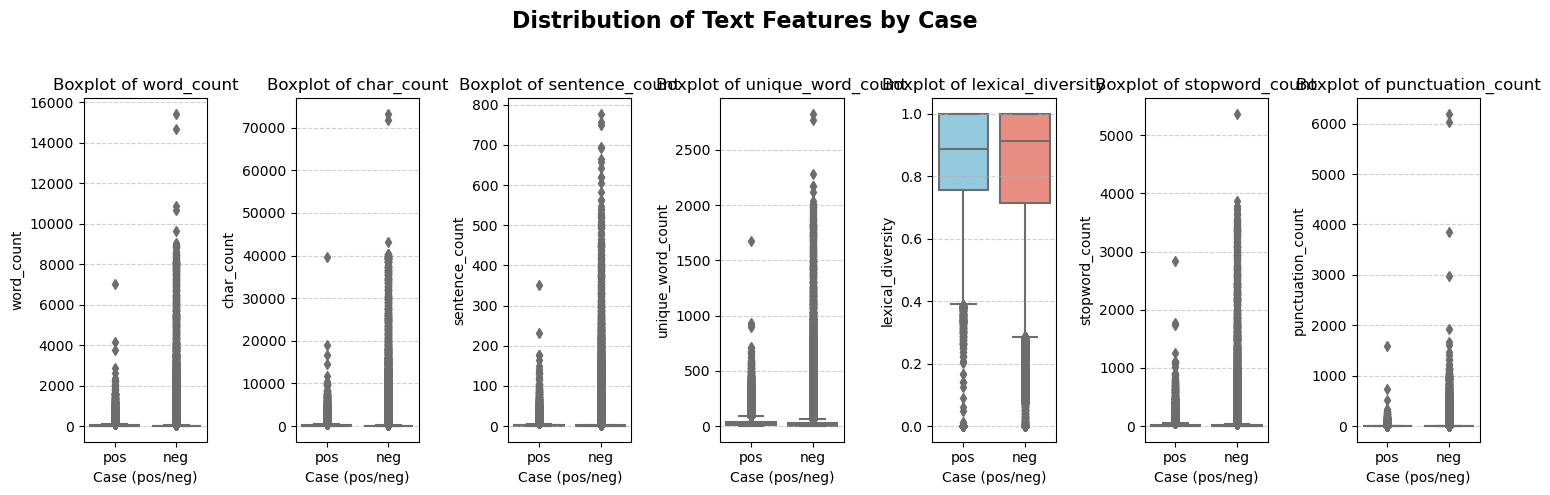

In [115]:
visualize_features(df_features)

In [126]:
analyze_ngrams_by_case(df_features, n=10, ngram_range=(1,3))

AttributeError: 'NoneType' object has no attribute 'lower'